# Building Blocks of PyTorch

#### System Imports

In [1]:
import os
import matplotlib.pyplot as plt

#### PyTorch Imports

In [2]:
import torch
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import transforms as T
from torch.nn import functional as F 
from torch import optim
from torch.nn import functional as F

#### Loading MNIST Dataset using Custom Dataset

In [3]:
class CustomMNISTDataset(Dataset):
	def __init__(self, dataset_path):
		self.dataset_path = dataset_path
		self.imgs, self.labels = [], []
		for dirpath, _, filenames in os.walk(self.dataset_path):
			self.imgs.extend([f"{dirpath}/{i}" for i in filenames])
			self.labels.extend([f"{dirpath.split('/')[-1]}" for _ in filenames])
			self.transform = T.Compose([T.Lambda(torch.flatten)])
			self.target_transform = T.Compose([T.Lambda(lambda x: torch.LongTensor([x])), T.Lambda(lambda x: F.one_hot(x, 10))])

	def __len__(self):
		# Returns the Size of the Dataset
		return len(self.imgs)

	def __getitem__(self, idx):
		# Returns a Sample from the data
		image = read_image(self.imgs[idx])
		label = int(self.labels[idx]) # Converting String Label to Integer
		image = self.transform(image)
		image = image / 255.0
		label = self.target_transform(label)
		return image, label

In [4]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(CustomMNISTDataset('/Users/atifadib/Deep_Learning_with_PyTorch/chapter3/output/'),
                              batch_size=64, shuffle=True)

#### Single Sample from MNIST Dataset

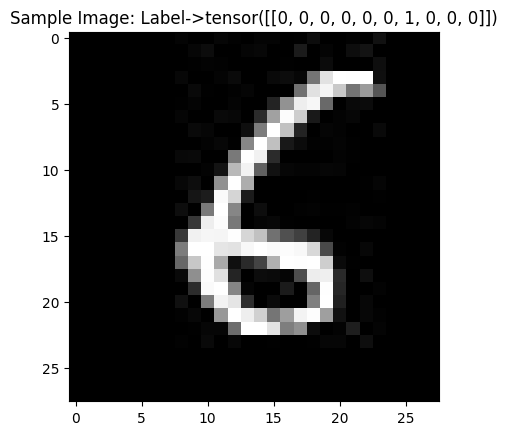

In [5]:
train_features, train_labels = next(iter(train_dataloader))
img = train_features[0].squeeze()
label = train_labels[0]
plt.title(f"Sample Image: Label->{label}")
plt.imshow(img.reshape(28,28), cmap="gray")
plt.show()

In [6]:
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 784])
Labels batch shape: torch.Size([64, 1, 10])


#### Simple Neural Network for Predicting Class of HandWritten Digits

In [7]:
from torch import nn
from torch.nn import functional as F

class NeuralNet(nn.Module):
    def __init__(self, h1, h2):
        super(NeuralNet, self).__init__() #Initializing superclass
        self.layer1 = nn.Linear(784, h1) #784 is the number of input features
        self.layer2 = nn.Linear(h1, h2)
        self.layer3 = nn.Linear(h2, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        out = F.log_softmax(x, dim=1)
        return x

### Training Loop in PyTorch

In [8]:
# Constants
lr = 0.005
epochs = 10

# Loading Dataset
train_dataset = CustomMNISTDataset('./output/training/')
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize Model
model = NeuralNet(512, 128)
# Initialize Optimizer
optimizer = optim.Adadelta(model.parameters(), lr=0.005)
# Loss function
loss_fn = nn.CrossEntropyLoss()

# set model to train mode
losses = []
model.train()
for epoch in range(epochs):
	batch_losses = []    
	for batch_idx, (data, targets) in enumerate(train_dataloader):
		optimizer.zero_grad()
		outputs = model(data)
		loss = loss_fn(outputs, targets.squeeze(1).float())
		loss.backward() # Backpropagation of loss
		optimizer.step() # Updating Weights based on Gradients
		batch_losses.append(loss.item())
	final_epoch_loss = torch.mean(torch.Tensor(batch_losses))
	losses.append(final_epoch_loss)
	print(f"{epoch}: {final_epoch_loss}")

0: 1.8479397296905518
1: 0.9750990271568298
2: 0.6475524306297302
3: 0.5225962996482849
4: 0.45880556106567383
5: 0.4211426377296448
6: 0.3965868055820465
7: 0.37958985567092896
8: 0.3659931421279907
9: 0.3560301959514618


#### Plotting Training Loss and Epoch

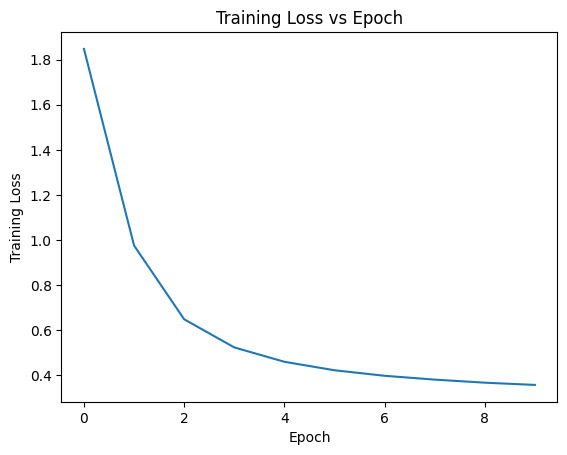

In [9]:
plt.title("Training Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.plot(range(epochs), losses)
plt.show()

#### Calculating Accuracy

In [11]:
# Load the test data
test_dataset = CustomMNISTDataset('./output/testing/')
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Set model to eval mode
model.eval()

# Loop over dataset to compute accuracy
correct = 0
for batch_idx, (data, targets) in enumerate(test_dataloader):
    outputs = model(data)
    pred = outputs.argmax(dim=1, keepdim=True) 
    correct += pred.eq(targets.argmax(dim=2).view_as(pred)).sum().item()
accuracy = correct / test_dataset.__len__()
print(f"Accuracy: {accuracy}")

Accuracy: 0.9028


#### Encapsulating Entire Training and Validation into one Function
#### Trainer Function

In [12]:
def trainer(config, epochs=10, data_dir=None):
    # Loading Dataset
    train_dataset = CustomMNISTDataset(data_dir+'/training/')
    train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)

    # Initialize Model
    model = NeuralNet(config["hidden_layer_1"], config["hidden_layer_2"])
    # Initialize Optimizer
    optimizer = optim.Adadelta(model.parameters(), lr=config["lr"])
    # Loss function
    loss_fn = nn.CrossEntropyLoss()
    
    checkpoint = session.get_checkpoint()

    if checkpoint:
        checkpoint_state = checkpoint.to_dict()
        start_epoch = checkpoint_state["epoch"]
        net.load_state_dict(checkpoint_state["net_state_dict"])
        optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    # set model to train mode
    losses = []
    model.train()
    for epoch in range(epochs):
        batch_losses = []    
        for batch_idx, (data, targets) in enumerate(train_dataloader):
            optimizer.zero_grad()
            outputs = model(data)
            loss = loss_fn(outputs, targets.squeeze(1).float())
            loss.backward() # Backpropagation of loss
            optimizer.step() # Updating Weights based on Gradients
            batch_losses.append(loss.item())
        final_epoch_loss = torch.mean(torch.Tensor(batch_losses))
        losses.append(final_epoch_loss.item())
        
    # Load the test data
    test_dataset = CustomMNISTDataset(data_dir+'/testing/')
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

    # Set model to eval mode
    model.eval()

    # Loop over dataset to compute accuracy
    correct = 0
    for batch_idx, (data, targets) in enumerate(test_dataloader):
        outputs = model(data)
        pred = outputs.argmax(dim=1, keepdim=True) 
        correct += pred.eq(targets.argmax(dim=2).view_as(pred)).sum().item()
    accuracy = correct / test_dataset.__len__()
    session.report({"loss": sum(losses) / len(losses), "accuracy": accuracy})

#### Setting Up Ray Tune Configs and Scheduler

In [13]:
from functools import partial
from ray import tune
from ray.air import Checkpoint, session
from ray.tune.schedulers import ASHAScheduler

max_num_epochs = 10
num_samples = 10

config = {
	"hidden_layer_1": tune.choice([512, 256]),
	"hidden_layer_2": tune.choice([128, 64]),
	"lr": tune.loguniform(1e-4, 1e-1),
	"batch_size": tune.choice([32, 48, 64])}

scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2,
    )

In [14]:
result = tune.run(
        partial(trainer,epochs=5, data_dir='/Users/atifadib/Deep_Learning_with_PyTorch/chapter3/output'),
        resources_per_trial={"cpu": 1, "gpus_per_trial": 0},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
    )

best_trial = result.get_best_trial("loss", "min", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss:  {best_trial.last_result['loss']}")
print(f"Best trial final validation loss:  {best_trial.last_result['accuracy']}")

2023-10-18 21:39:56,322	INFO worker.py:1642 -- Started a local Ray instance.
2023-10-18 21:39:57,151	INFO tune.py:228 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2023-10-18 21:39:57,153	INFO tune.py:645 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Trial name,accuracy,loss
trainer_8e1f6_00000,0.9109,0.538548
trainer_8e1f6_00001,0.8061,1.47806
trainer_8e1f6_00002,0.8321,1.40495
trainer_8e1f6_00003,0.6958,2.16802
trainer_8e1f6_00004,0.8054,1.5946
trainer_8e1f6_00005,0.9141,0.482466
trainer_8e1f6_00006,0.5104,2.24629
trainer_8e1f6_00007,0.8383,1.34412
trainer_8e1f6_00008,0.415,2.25873
trainer_8e1f6_00009,0.917,0.468081


2023-10-18 21:42:44,171	INFO tune.py:1143 -- Total run time: 167.02 seconds (166.98 seconds for the tuning loop).


Best trial config: {'hidden_layer_1': 512, 'hidden_layer_2': 128, 'lr': 0.012746297610971511, 'batch_size': 32}
Best trial final validation loss:  0.46808149814605715
Best trial final validation loss:  0.917


#### Saving and Reloading a Model

In [17]:
torch.save(model.state_dict(), 'model.pth')

In [20]:
model_new = NeuralNet(512, 128)

In [21]:
model_new.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>